### Exercício Computacional IV

#### Rafael Aeraf e Taiguara Tupinambás


#### Enunciado
Nesse exercício vocês irão implementar o sistema nebuloso adaptativo visto em sala de aula para aproximar a função sinc(x) no intervalo [0,2*pi].

Em anexo, segue a descrição do modelo, incluindo as derivadas parciais da função de custo em relação aos parâmetros do modelo.

Vocês devem entregar um arquivo fonte com a implementação do algoritmo. O arquivo deve treinar o modelo, plotar o resultado da aproximação e imprimir o RMSE. 

In [221]:
import pandas as pd
import numpy as np
from pandas import MultiIndex
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
import time
import scipy.io
from scipy import signal
import random
from PIL import Image
import inspect
from IPython.display import display

Inicialmente, foram definidas funções para facilitar os cálculos da saída do modelo:

- Função *calcula_mu_w*, que retorna:
    
    $\mu_{A\textit{lk}}(x_{il})=exp \bigg( -\frac{1}{2}\frac{(x_{il}-c_{lk})^2}{\sigma_{lk}^2} \bigg)
    \\w_k=\mu_{A\textit{1k}}(x_{i1})\mu_{A\textit{2k}}(x_{i2})...\mu_{A\textit{dk}}(x_{id})$


In [222]:
def calcula_mu_w(x,c,sigma): # x deve ser um ponto
    """x deve ser sempre uma amostra, i.e. um vetor de dimensão d"""
    mu = np.exp((-1/2)*(np.power(np.tile(x,(1,c.shape[0])).T-c, 2)/np.power(sigma,2)))
    w = pd.DataFrame(np.prod(mu,axis=1))
    return[mu,w]

- Função *calcula_z*, que retorna $y_k$ do artigo:
    
    $z_k=p_{1k}x_{i1}+p_{2k}x_{i2}+...+p_{dk}x_{id}+q_k$


In [223]:
def calcula_z(p,q,x): # x deve ser um ponto
    """x deve ser sempre uma amostra, i.e. um vetor de dimensão d"""
    z = pd.DataFrame((np.sum(p*pd.DataFrame(np.tile(x,(1,p.shape[0]))).T,axis=1)+q.T)).T
    return z

- Função *calcula_y_hat*, que retorna $\hat{y}_i$ do artigo:
    
    $\hat{y}_i=\frac{\sum_{k=1}^m w_ky_k}{\sum_{k=1}^m w_k}$

In [224]:
def calcula_y_hat(w,z):
    """x deve ser sempre uma amostra, i.e. um vetor de dimensão d"""
    y_hat = ((np.sum(z*w))/np.sum(w))[0]
    return y_hat

Em seguida, foram definidas funções para atualização dos parâmetros do modelo, conforme algoritmo do gradiente descendente:

$c_{lk} = c_{lk} - \alpha \frac{\delta J}{\delta c_{lk}}
\\ \sigma_{lk} = \sigma_{lk} - \alpha \frac{\delta J}{\delta \sigma_{lk}}
\\ p_{lk} = p_{lk} - \alpha \frac{\delta J}{\delta p_{lk}}
\\ q_{k} = q_{qk} - \alpha \frac{\delta J}{\delta q_{k}}$


In [225]:
def atualiza_c(y_hat, w, mu, c, sigma, z, x, y, alfa):
    """x deve ser sempre uma amostra, i.e. um vetor de dimensão d"""
    aux = -2*(y-y_hat)[0]
    aux = aux*(z-y_hat)/np.sum(w)
#     aux = np.tile(aux,x.shape[1])*pd.DataFrame(np.tile(w,x.shape[1]))/mu
    aux = aux*mu*((pd.DataFrame(np.tile(x,(1,c.shape[0])).T-c)/np.power(sigma,2)))

    c_new = c - alfa*aux
    return c_new

In [226]:
def atualiza_sigma(y_hat, w, mu, c, sigma, z, x, y, alfa):
    """x deve ser sempre uma amostra, i.e. um vetor de dimensão d"""
    aux = -2*(y-y_hat)[0]
    aux = aux*(z-y_hat)/np.sum(w)
#     aux = np.tile(aux,x.shape[1])*pd.DataFrame(np.tile(w,x.shape[1]))/mu
    aux = aux*mu*(np.power(pd.DataFrame(np.tile(x,(1,c.shape[0])).T-c),2)/np.power(sigma,3))

    sigma_new = sigma - alfa*aux
    return sigma_new

In [227]:
def atualiza_p(y_hat, w, sigma, x, y, alfa, p):
    """x deve ser sempre uma amostra, i.e. um vetor de dimensão d"""
    aux = -2*(y-y_hat)[0]
    aux = aux*(w/np.sum(w))
    aux = np.tile(aux,x.shape[1])*np.tile(x,(p.shape[0],1))
    
    p_new = p - alfa*aux
    return p_new

In [228]:
def atualiza_q(y_hat, w, sigma, y, alfa, q):
    """x deve ser sempre uma amostra, i.e. um vetor de dimensão d"""
    aux = -2*(y-y_hat)[0]
    aux = aux*(w/np.sum(w))
    
    q_new = q - alfa*aux
    return q_new

Os hiperparâmetros do modelo são declarados, sendo:
- $m$, o número de regras do modelo
- $alfa$, a taxa de aprendizagem
- $num\_pontos$, a quantidade de pontos simulada, para a aproximação
- $eps$, critério de parada por convergência
- $epocas$, critério de parada por tempo de simulação

#### Para determinar os valores otimizados dos hiperparâmetros, foi utilizado um algorítmo anexado ao final do trabalho.

In [229]:
# hiperparametros
m = 7
alfa = 0.02
num_pontos = 800
eps = 1e-6
epocas = 40

Os dados são simulados, utilizando a função *sinc* da biblioteca *numpy*, de $0$ a $2\pi$.

In [230]:
# conjunto de dados
x = pd.DataFrame(np.linspace(0,2*np.pi,num_pontos))
y = pd.DataFrame(np.sinc(x))
d = x.shape[1] # dimensão de x

Os parâmetros iniciais do modelo são escolhidos de forma aleatória, de forma que:
- $c_{lk}\sim U[min(x_l),max(x_l)]$ 
- $\sigma_{lk}\sim U(0,1]$
- $p_{lk}\sim U[-1,1]$
- $q_{lk}\sim U[-1,1]$

In [231]:
# Inicialização dos parâmetros
c = pd.DataFrame(np.random.uniform(np.min(x,axis=0),np.max(x,axis=0),(m,d))) 
p = pd.DataFrame(np.random.uniform(-1,1,(m,d)))
q = pd.DataFrame(np.random.uniform(-1,1,(m,1)))
sigma = pd.DataFrame(np.random.uniform(0,1,(m,d))) 
while 0 in sigma.values:
    sigma = sigma.replace(0,np.random.uniform(0,1))

Em seguida, o algoritmo é executado, respeitando os critérios de parada.
Os valores finais de *$c, p, q$* e *$\sigma$* configuram o modelo obtido e serão utilizados para estimar a função sinc.

In [232]:
i = 0 # contador de iterações
N = 0 # contador de épocas
dif = 1 # variação do vetor de parâmetros
a=[] # armazena o valor de dif ao longo das iterações
J=[] # armazena o erro estocástico ao longo das iterações
start = time.time()

# variáveis utilizadas para visualizar a variação dos parâmetros ao longo das iterações
c_m=pd.DataFrame(np.zeros((m,1)))
sigma_m=pd.DataFrame(np.zeros((m,1)))
p_m=pd.DataFrame(np.zeros((m,1)))
q_m=pd.DataFrame(np.zeros((m,1)))
mu_m=pd.DataFrame(np.zeros((m,1)))

while dif>eps and N<=epocas: # loop das épocas

    # Randomizando a ordem dos pontos
    index = np.random.permutation(len(x))
    xr = x.loc[index].reset_index(drop=True)
    yr = y.loc[index].reset_index(drop=True)

    while i<x.shape[0] and dif>eps: # loop dos pontos
        
        # Seleciona os pontos atuais
        xi = xr[i:i+1].reset_index(drop=True)
        yi = yr[i:i+1].reset_index(drop=True)

        # calcula mu, w, z e y_hat
        [mu,w] = calcula_mu_w(xi,c,sigma)
        z = calcula_z(p,q,xi)
        y_hat = calcula_y_hat(w,z)
    
        #atualiza os parâmetros
        c_new = atualiza_c(y_hat, w, mu, c, sigma, z, xi, yi, alfa)
        sigma_new = atualiza_sigma(y_hat, w, mu, c, sigma, z, xi, yi, alfa)
        p_new = atualiza_p(y_hat, w, sigma, xi, yi, alfa, p)
        q_new = atualiza_q(y_hat, w, sigma, yi, alfa, q)
    
        #calcula a norma
        norma = [np.linalg.norm(c-c_new),np.linalg.norm(sigma-sigma_new),np.linalg.norm(p-p_new),np.linalg.norm(q-q_new)]
        
        #calcula critério de parada
        dif = max(norma)
        a.append(dif) #armazena critério de parada
    
        #atualiza os valores de parâmetros
        if not math.isnan(dif):  #filtro para evitar erros de parâmetros não numéricos
            c = c_new
            sigma = sigma_new
            p = p_new
            q = q_new

        i+=1
        
        #armazena os parâmetros para avaliar a variação ao longo do tempo
        c_m.loc[:,i]=c_new
        sigma_m.loc[:,i]=sigma_new
        p_m.loc[:,i]=p_new
        q_m.loc[:,i]=q_new
        mu_m.loc[:,i]=mu
        J.append(abs(y_hat-yi))
        
    N += 1
    i = 0

# armazena o tempo total de execução do algorítmo
end = time.time()

In [233]:
print("Tempo de execução: %.2f minutos. Número de épocas: %i. Valor final de dif: %.4g." %((end - start)/60, N, dif))

Tempo de execução: 0.83 minutos. Número de épocas: 4. Valor final de dif: 5.656e-07.


Com base nos parâmetros finais, o valor de $y$ é estimado pelo algoritmo, através das funções que calculam a saída do modelo, para cada ponto de $x$.
O resultado da aproximação é apresentada em seguida, assim como o RMSE e gráficos de evolução dos parâmetros ao longo das iterações do algoritmo.

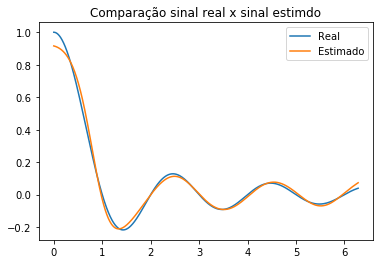

In [234]:
y_est=[]

for i in range(x.shape[0]):
    xi = x[i:i+1].reset_index(drop=True)
    [mu,w] = calcula_mu_w(xi,c,sigma)
    z = calcula_z(p,q,xi)
    y_est.append(calcula_y_hat(w,z))
    
plt.plot(x,y)
plt.plot(x,y_est)
plt.title("Comparação sinal real x sinal estimdo")
plt.legend(("Real","Estimado"))
plt.show()

Para auxiliar na análise da eficiência do algorítmo, os valores do erro estocástico e do parâmetro de convergência são exibido ao longo das iterações.

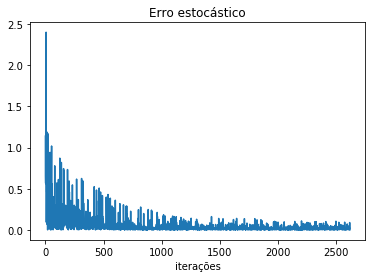

In [235]:
plt.plot(range(len(J)),J)
plt.title("Erro estocástico")
plt.xlabel("iterações")
plt.show()

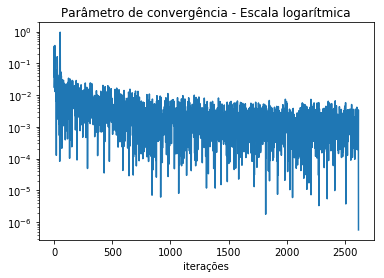

In [236]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(len(a)),a)
plt.title("Parâmetro de convergência - Escala logarítmica")
ax.set_yscale('log')
plt.xlabel("iterações")
plt.show()

O valor do erro quadrático médio é calculado para avaliar a aproximação.

In [237]:
RMSE = np.sqrt(np.mean((pd.DataFrame(y_est)-y)**2))
print("RMSE: %.4g" %RMSE[0])

RMSE: 0.025


Por último, a variação dos parâmetros a cada iteração é plotada para analisar a convergência do modelo.

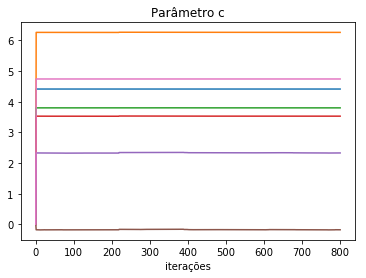

In [238]:
for i in range(m):
    plt.plot(range(c_m.shape[1]),c_m.loc[i,:])
plt.title("Parâmetro c")
plt.xlabel("iterações")
plt.show()

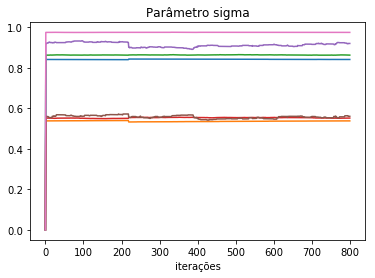

In [239]:
for i in range(m):
    plt.plot(range(sigma_m.shape[1]),sigma_m.loc[i,:])
plt.title("Parâmetro sigma")
plt.xlabel("iterações")
plt.show()

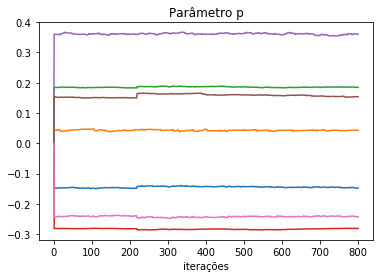

In [240]:
for i in range(m):
    plt.plot(range(p_m.shape[1]),p_m.loc[i,:])
plt.title("Parâmetro p")
plt.xlabel("iterações")
plt.show()

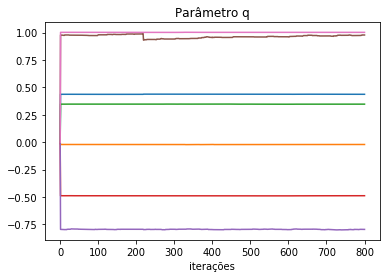

In [241]:
for i in range(m):
    plt.plot(range(q_m.shape[1]),q_m.loc[i,:])
plt.title("Parâmetro q")
plt.xlabel("iterações")
plt.show()

#### Escolha de hiperparâmetros
Para auxiliar na escolha dos hiperparâmetros, o algorítmo abaixo foi utilizado. Nele são realizados os seguintes passos:
- os hiperparâmetros são escolhidos aleatoriamente em uma lista de possíveis valores definida anteriormente;
- o algorítmo de gradiente descendente é aplicado para esses hiperparâmetros;
- caso um tempo limite seja atingido (30 segundos por época ou 3 minutos por modelo), o grupo de hiperparâmetros é descartado,
- em seguida o valor de RMSE é calculado e caso seja inferior a um limite, os hiperparâmetros e seus resultados são armazenados em uma tabela,
- novos hiperparâmetros são sorteados e o algorítmo se repete até que um tempo limite seja atendido.
Observando a tabela de resultados e os valores da lista de possíveis hiperparâmetros são atualizados, atingindo aqueles valores que não levam a bons resultados de RMSE. O algorítmo é então executado novamente até que se chegue a hiperparâmetros que obtenham um resultado satisfatório em um tempo aceitável.

In [242]:
# # lista de possíveis hiperparâmetros definida baseando nos testes realizados
# m_all = [4, 5, 6, 7]
# alfa_all = [0.001, 0.004, 0.008, 0.01, 0.02] #[0.001, 0.004, 0.008, 0.01, 0.02, 0.04, 0.08, 0.1, 0.2]
# num_pontos_all = [100, 200, 400, 800, 1000] #[100, 200, 400, 800, 1000, 1500, 2000]
# eps_all = [1e-5, 1e-6, 1e-7, 1e-8] #[1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
# epocas_all = [10, 20, 40, 80, 100, 200] #[10, 20, 40, 80, 100, 200, 400, 600, 800, 1000, 1500, 2000]

# # variável que armazena os resultados dos testes bem sucedidos
# resultado = pd.DataFrame(columns=["m","alfa","num_pontos","eps","epocas","N","dif","tempo_modelo","RMSE"])
# RMSE_atual = 9999999999999 # variável que armazena o melhor resultado obtido
# N_modelos = 0 # total de modelos avaliados
# start_total = time.time()
# tempo_total = 0 # contagem de tempo total do algorítmo
# tempo_epoca_exit = False # variável que indica que uma época estourou o tempo máximo definido
# tempo_modelo_exit = False # variável que indica que um modelo estourou o tempo máximo definido
# tempo_epoca_max = 0.5*60 # tempo máximo permitido para cada época
# tempo_modelo_max = 3*60 # tempo máximo permitido para cada modelo

# while tempo_total < 60*60 and RMSE_atual>0.001: # loop de tempo máximo do algorítmo

#     # sorteia hiperparametros
#     m = random.choice(m_all)
#     alfa = random.choice(alfa_all)
#     num_pontos = random.choice(num_pontos_all)
#     eps = random.choice(eps_all)
#     epocas = random.choice(epocas_all)
    
#     # conjunto de dados
#     x = pd.DataFrame(np.linspace(0,2*np.pi,num_pontos))
#     y = pd.DataFrame(np.sinc(x))
#     d = x.shape[1]
    
#     # Inicialização dos parâmetros
#     c = pd.DataFrame(np.random.uniform(np.min(x,axis=0),np.max(x,axis=0),(m,d))) 
#     p = pd.DataFrame(np.random.uniform(-1,1,(m,d)))
#     q = pd.DataFrame(np.random.uniform(-1,1,(m,1)))
#     sigma = pd.DataFrame(np.random.uniform(0,1,(m,d))) 
#     while 0 in sigma.values:
#         sigma = sigma.replace(0,np.random.uniform(0,1))
        
#     i = 0 # contador de iterações
#     N = 0 # contador de épocas
#     dif = 1 # variação do vetor de parâmetros
#     start_modelo = time.time()
#     tempo_modelo = 0 # contagem de tempo de cada modelo

#     while dif>eps and N<=epocas and tempo_epoca_exit==False and tempo_modelo_exit==False: # loop de modelos

#         # Randomizando a ordem dos pontos
#         index = np.random.permutation(len(x))
#         xr = x.loc[index].reset_index(drop=True)
#         yr = y.loc[index].reset_index(drop=True)
        
#         tempo_epoca = 0 # contagem de tempo de cada época
#         start_epoca = time.time()

#         while i<x.shape[0] and dif>eps and tempo_epoca_exit==False: # loop de épocas
            
#             # Seleciona os pontos atuais
#             xi = xr[i:i+1].reset_index(drop=True)
#             yi = yr[i:i+1].reset_index(drop=True)

#             # calcula mu, w, z e y_hat
#             [mu,w] = calcula_mu_w(xi,c,sigma)
#             z = calcula_z(p,q,xi)
#             y_hat = calcula_y_hat(w,z)

#             #atualiza os parâmetros
#             c_new = atualiza_c(y_hat, w, mu, c, sigma, z, xi, yi, alfa)
#             sigma_new = atualiza_sigma(y_hat, w, mu, c, sigma, z, xi, yi, alfa)
#             p_new = atualiza_p(y_hat, w, sigma, xi, yi, alfa, p)
#             q_new = atualiza_q(y_hat, w, sigma, yi, alfa, q)

#             #calcula a norma
#             norma = [np.linalg.norm(c-c_new),np.linalg.norm(sigma-sigma_new),np.linalg.norm(p-p_new),np.linalg.norm(q-q_new)]

#             #calcula critério de parada
#             dif = max(norma)

#             #atualiza os valores de parâmetros
#             if not math.isnan(dif):  #filtro para evitar erros de parâmetros não numéricos
#                 c = c_new
#                 sigma = sigma_new
#                 p = p_new
#                 q = q_new

#             i+=1
            
#             # caso o tempo da época atinja o limite, define o fim da execução do modelo
#             tempo_epoca = time.time()-start_epoca
#             if tempo_epoca > tempo_epoca_max:
#                 tempo_epoca_exit = True

#         N += 1
#         i = 0
        
#         # caso o tempo do modelo atinja o limite, define o fim da execução do modelo
#         tempo_epoca = 0
#         tempo_modelo = time.time()-start_modelo
#         if tempo_modelo > tempo_modelo_max:
#             tempo_modelo_exit = True
    
#     # calcula o RMSE
#     y_est=[]
#     for i in range(x.shape[0]):
#         xi = x[i:i+1].reset_index(drop=True)
#         [mu,w] = calcula_mu_w(xi,c,sigma)
#         z = calcula_z(p,q,xi)
#         y_est.append(calcula_y_hat(w,z))
#     RMSE = np.sqrt(np.mean((pd.DataFrame(y_est)-y)**2))[0]
    
#     # caso o tempo não tenha sido excedido e o resultado do RMSE esteja dentro do limite, armazena o resultado
#     if RMSE < 0.2 and tempo_modelo_exit==False and tempo_epoca_exit==False:
#         resultado.loc[len(resultado)+1,"m"]=m
#         resultado.loc[len(resultado),"alfa"]=alfa
#         resultado.loc[len(resultado),"num_pontos"]=num_pontos
#         resultado.loc[len(resultado),"eps"]=eps
#         resultado.loc[len(resultado),"epocas"]=epocas
#         resultado.loc[len(resultado),"N"]=N
#         resultado.loc[len(resultado),"dif"]=dif
#         resultado.loc[len(resultado),"tempo_modelo"]=tempo_modelo
#         resultado.loc[len(resultado),"RMSE"]=RMSE
#         if RMSE < RMSE_atual:
#             RMSE_atual = RMSE #armazena o melhor RMSE obtido até o momento
#             print("modelos - %i RMSE_atual - %f" %(N_modelos, RMSE_atual))
        
#     tempo_total = time.time() - start_total
#     N_modelos += 1
#     tempo_epoca_exit = False
#     tempo_modelo_exit = False